### Project Part 3

#### Alex Barrios (u96011930)

#### Stephani Crous (u17014663)

#### Phathutshedzo Maungo (u14026962)

### 1) Parameter Estimation: Nonlinear Model

#### Imports

In [1]:
import numpy
import tclab
from matplotlib import pyplot as plt
from tclab import TCLab, clock, Historian, Plotter, setup
%matplotlib inline

#### Parameters of Fin bank 1 (F1)

In [17]:
AF1 = 0.0004*10                    # m2
AFIN1 = 0.00009                 # m2
VF1 = 0.00036                   # m3
mF1 = 0.0029                    # kg
CpF1 = 502.42  *0.8                 # J.kg-1.C-1
rhoF1 = 7900                    # kg.m-3
hF1 = 10.45    *1.3      # W.m-2.K-1

#### Parameters of Fin bank 2 (F2)

In [18]:
AF2 = 0.0004                 # m2
VF2 = 0.00036                   # m3
CpF2 = 502.42  *0.8                  # J.kg-1.C-1
mF2 =  0.0029                   # kg
rhoF2 =  7900                   # kg.m-3
hF2 = 10.45    *1.3          # W.m-2.K-1

#### Parameters of Heater 1 (H1)

In [20]:
kH1 = 14.4/1000                 # W.m-1.K-1
AH1 = 0.00008*10                   # m2
LH1 = 0.0015                    # m
mH1 = 0.00019                   # kg
CpH1 = 502.42    *0.8               # J.kg-1.C-1
hH1 = 10.45 * 1.3     # W.m-2.K-1

#### Parameters of Heater 2 (H2)

In [21]:
kH2 = 14.4/1000                 #W.m-1.K-1
AH2 = 0.00008                 # m2
LH2 = 0.0015                    # m
mH2 = 0.00019                   # kg
CpH2 = 502.42      *0.8               # J.kg-1.C-1
hH2 = 10.45 * 1.3     # W.m-2.K-1

#### Parameters of Sensor 1 (S1)

In [22]:
AS1 = 0.000016                  # m2
mS1 = 0.00025                   # kg
CpS1 = 502.42        *0.8             # J.kg-1.C-1
hS1 = 10.45 *1.3        # W.m-2.K-1

#### Parameters of Sensor 2 (S2)

In [24]:
AS2 = 0.000016                  # m2
mS2 = 0.00025                   # kg
CpS2 = 502.42*0.8                  # J.kg-1.C-1
hS2 = 10.45 *1.3      # W.m-2.K-1

#### Other Parameters

In [25]:
alpha1 = 0.01                    # W
alpha2 = 0.0075                  # W                        # CHANGE               
h_amb = 10.45  *1.3               # W.m-2.K-1
T_amb = 294.15                   # K                        # CHANGE
E = 0.85                         # Emissivity
sigma = 5.67*(10**-8)            # Stefan-Boltzmann constant
rho_ss = 7900                    # Density of stainless steel (kgm-3)

#### Inputs to step and rectangular disturbances

In [9]:
M0 = 0
M1 = 100
M2 = 0
ts1 = 30
ts2 = 900

#### Step and rectangular disturbances

In [10]:
def Q_rect(t, M0, M1, M2, ts1, ts2):
    if t < ts1:
        return M0
    
    elif ts1 < t < ts2:
        return M1
    
    else:
        return M2
    
def Q_step(t, M0, M1, ts1):
    if t < ts1:
        return M0
    
    else:
        return M1

#### Model

#### Step input

In [11]:
# Differential Equations

def diff(t, T):
    TF1, TF2, TH1, TH2, TS1, TS2 = T
    QIN1 = Q_step(t, M0, M1, ts1)
    QIN2 = Q_step(t, M0, 0, ts1)
        
    # Fin Equations

    Qconv_1 = h_amb*AF1*(TF1 - T_amb)
    Qconv_2 = h_amb*AF2*(TF2 - T_amb)

    Qcond_1 = ((kH1*AH1*0.075)/LH1)*(TH1 - TF1)             # CHANGE
    Qcond_2 = ((kH2*AH2*0.075)/LH2)*(TH2 - TF2)             # CHANGE

    #Qrad_1 = E*sigma*AF1*((TF1**4) - (T_amb**4))
    #Qrad_2 = E*sigma*AF2*((TF2**4) - (T_amb**4))

    Qconv_12 = h_amb*(AFIN1)*(TF1 - TF2)
    #Qrad_12 = E*sigma*(AFIN1)*((TF1**4) - (TF2**4))
    
    # Heater Equations

    QH1_F1 = ((kH1*AH1*0.075)/LH1)*(TH1 - TF1)              # CHANGE
    QH2_F2 = ((kH2*AH2*0.075)/LH2)*(TH2 - TF2)              # CHANGE

    QH1_S1 = ((kH1*AH1*0.075)/LH1)*(TH1 - TS1)              # CHANGE
    QH2_S2 = ((kH2*AH2*0.075)/LH2)*(TH2 - TS2)              # CHANGE

    QH1_conv = hH1*AH1*(TH1 - T_amb)
    QH2_conv = hH2*AH2*(TH2 - T_amb)

    #QH1_rad = E*sigma*AH1*((TH1**4) - (T_amb**4))
    #QH2_rad = E*sigma*AH2*((TH2**4) - (T_amb**4))
    
    # Sensor Equations

    QS1_cond = QH1_S1
    QS2_cond = QH2_S2

    QS1_conv = hS1*AS1*(TS1 - T_amb)                  
    QS2_conv = hS2*AS2*(TS2 - T_amb)                  

    #.QS1_rad = E*sigma*AS1*((TS1**4) - (T_amb**4))
    #QS2_rad = E*sigma*AS2*((TS2**4) - (T_amb**4))
    
    # Differential Equations
    
    dTF1dt = (1/(mF1*CpF1))*(-Qconv_1  + Qcond_1 - Qconv_12)
    dTF2dt = (1/(mF2*CpF2))*(-Qconv_2  + Qcond_2 + Qconv_12)

    dTH1dt = (1/(mH1*CpH1))*(-QH1_F1 - QH1_S1 - QH1_conv  + alpha1*QIN1)
    dTH2dt = (1/(mH2*CpH2))*(-QH2_F2 - QH2_S2 - QH2_conv  + alpha2*QIN2)

    dTS1dt = (1/(mS1*CpS1))*(QS1_cond - QS1_conv)
    dTS2dt = (1/(mS2*CpS2))*(QS2_cond - QS2_conv)

    return dTF1dt, dTF2dt, dTH1dt, dTH2dt, dTS1dt, dTS2dt

In [12]:
TCLab = setup(connected = False, speedup = 1)
tfinal = 600
t_step = 1

In [13]:
tspan = []

In [14]:
def T1_model():
    return Tss1

def T2_model():
    return Tss2

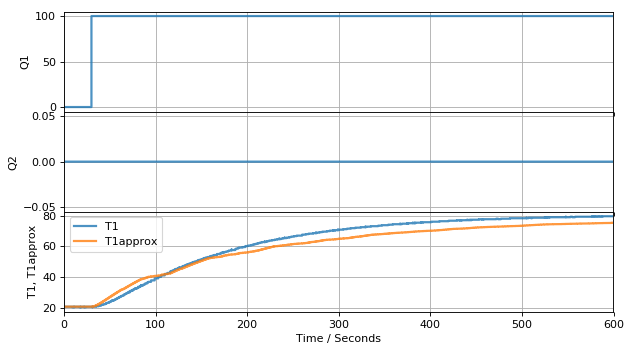

TCLab Model disconnected successfully.


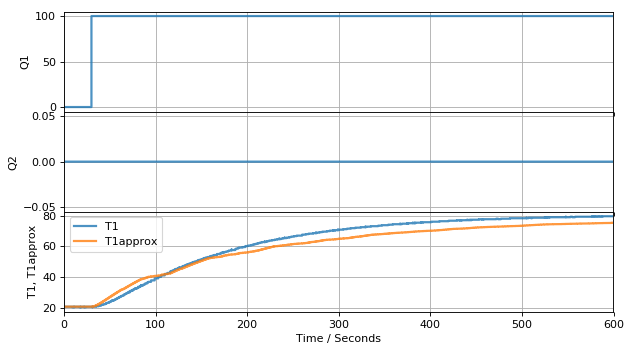

In [15]:
with TCLab() as lab:
    
    hist = Historian(lab.sources + [('T1approx', T1_model)] + [('T2approx', T2_model)])
    p = Plotter(hist, tfinal, layout=(('Q1',), ('Q2',), ('T1', 'T1approx')))
    #hist = Historian(lab.sources)
    #p = Plotter(hist, tfinal)
    dt = t_step
    To = [294.15, 294.15, 294.15, 294.15, 294.15, 294.15]
    TF1, TF2, TH1, TH2, TS1, TS2 = To
    TS1s = []
    TS2s = []
    Tlab1 = []
    Tlab2 = []

    for t in tclab.clock(tfinal, t_step):
        
        lab.Q1(Q_step(t, M0, M1, ts1))
        lab.Q2(Q_step(t, M0, 0, ts1))           

        To = TF1, TF2, TH1, TH2, TS1, TS2 
        dTF1dt, dTF2dt, dTH1dt, dTH2dt, dTS1dt, dTS2dt = diff(t, To)

        TF1 += dTF1dt*dt
        TF2 += dTF2dt*dt
        TH1 += dTH1dt*dt
        TH2 += dTH2dt*dt
        TS1 += dTS1dt*dt
        TS2 += dTS2dt*dt

        To = TF1, TF2, TH1, TH2, TS1, TS2
        Tss1 = TS1-273.15
        Tss2 = TS2-273.15
        TS1s.append(TS1-273.15)
        TS2s.append(TS2-273.15)
        Tlab1.append(lab.T1)
        Tlab2.append(lab.T2)
        tspan.append(t)
        hist.update(t)
        p.update(t)
    plt.savefig('Temp_real.svg')

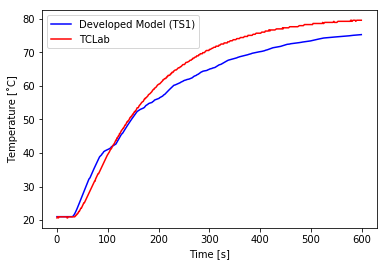

In [16]:
plt.plot(tspan, TS1s, "b-", label = 'Linear Model (TS1)')
plt.plot(tspan, Tlab1, "r-", label = 'TCLab')
plt.xlabel("Time [s]")
plt.ylabel("Temperature [˚C]")
plt.legend(loc='best')
plt.savefig('TS1_tempcurve_real_step.svg')
plt.show()

#### 2) Parameter Estimation: Linear Model

#### 3) Step Size

#### 4) Linearity